<a href="https://colab.research.google.com/github/L1ttle-tra1n/GDP/blob/main/sam_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Video Segmentation**

In [7]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-1qqt6bx1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-1qqt6bx1
  Resolved https://github.com/facebookresearch/sam2.git to commit c2ec8e14a185632b0a5d8b161928ceb50197eddc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Load Leukemia video
import cv2
import os

!mkdir -p videos

video_path = '/content/drive/MyDrive/GDPData/Leukemia1.mp4'
output_folder = 'videos/frames/leukemia'
grayscale_folder = 'videos/frames/leukemia_grayscale'

!mkdir -p {output_folder}
!mkdir -p {grayscale_folder}

!ffmpeg -i "{video_path}" -q:v 2 {output_folder}/%05d.jpg

for frame_file in sorted(os.listdir(output_folder)):
    frame_path = os.path.join(output_folder, frame_file)
    if frame_file.endswith('.jpg'):
        img = cv2.imread(frame_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_frame_path = os.path.join(grayscale_folder, frame_file)
        cv2.imwrite(gray_frame_path, gray_img)

!mkdir -p ../checkpoints/
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
# Load Breast video

# !mkdir -p videos

# video_path = '/content/drive/MyDrive/GDPData/Breast1.mp4'
# output_folder = 'videos/frames/Breast'

# !mkdir -p {output_folder}
# !ffmpeg -i "{video_path}" -q:v 2 {output_folder}/%05d.jpg

# !mkdir -p ../checkpoints/
# !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
# Delete all in such file
# !rm -rf videos/frames/*

In [10]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [12]:
# Loading Predictor

from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

/usr/local/lib/python3.10/dist-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [13]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### **Leukemia Video**

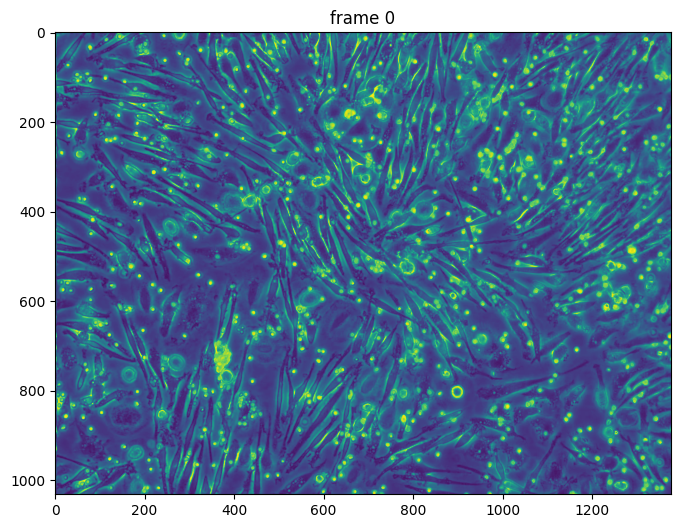

In [14]:
video_dir = './videos/frames/leukemia_grayscale'

frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [15]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 570/570 [00:29<00:00, 19.17it/s]


In [47]:
predictor.reset_state(inference_state)

In [48]:
prompts = {}

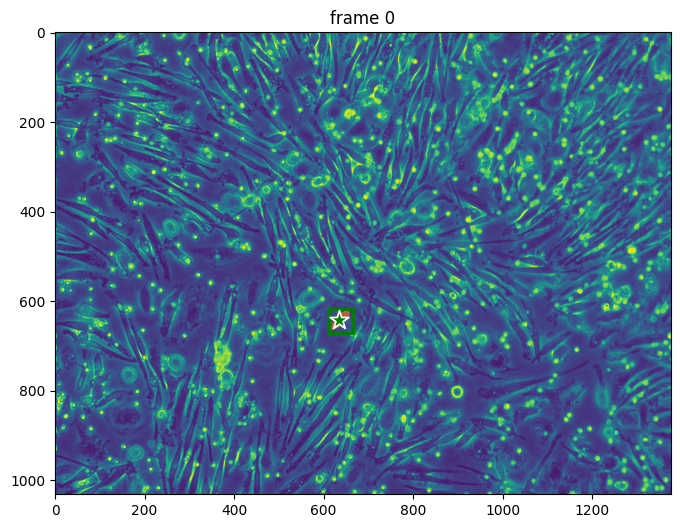

In [49]:
ann_frame_idx = 0
ann_obj_id = 1

points = np.array([[635, 643]], dtype=np.float32)

labels = np.array([1], np.int32)

box = np.array([612, 617, 666, 672], dtype=np.float32) # (x_min, y_min, x_max, y_max)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
    box=box,
)

plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

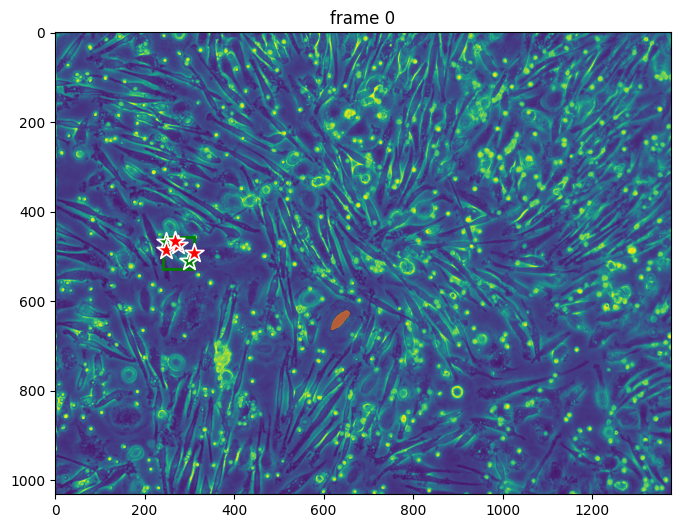

In [50]:
ann_frame_idx = 0
ann_obj_id = 2

points = np.array([[248, 468],[299, 510],[248, 485],[274, 475],[269, 465],[311, 493]], dtype=np.float32)

labels = np.array([1,1,0,0,0,0], np.int32)

box = np.array([240, 456, 310, 529], dtype=np.float32) # (x_min, y_min, x_max, y_max)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
    box=box,
)

plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

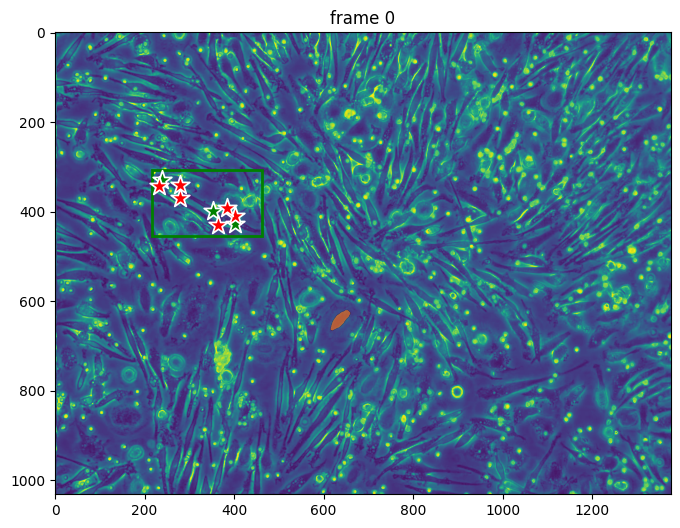

In [51]:
ann_frame_idx = 0
ann_obj_id = 3

points = np.array([[239, 329],[401, 427],[352, 399],[233, 343],[280, 370],[363, 431],[403, 409],[384, 393],[279, 340]], dtype=np.float32)

labels = np.array([1,1,1,0,0,0,0,0,0], np.int32)

box = np.array([216, 307, 463, 454], dtype=np.float32) # (x_min, y_min, x_max, y_max)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
    box=box,
)

plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

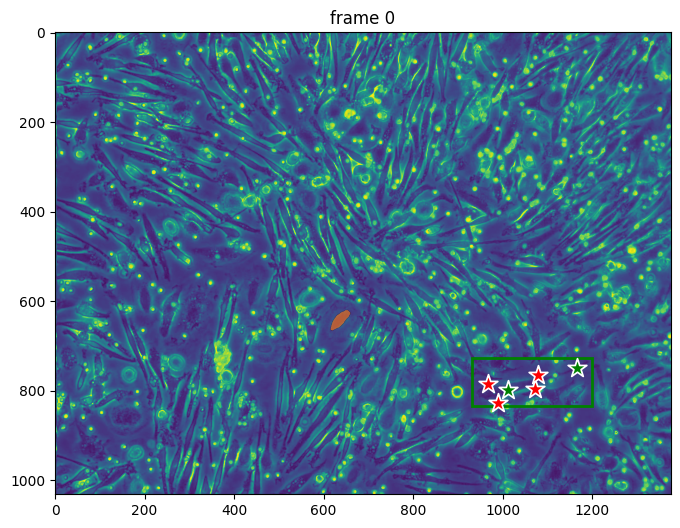

In [45]:
ann_frame_idx = 0
ann_obj_id = 4

points = np.array([[1166, 749],[1012, 798],[1073, 796],[1079, 766],[990, 828],[968, 785]], dtype=np.float32)

labels = np.array([1,1,0,0,0,0], np.int32)

box = np.array([931, 727, 1200, 835], dtype=np.float32) # (x_min, y_min, x_max, y_max)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
    box=box,
)

plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

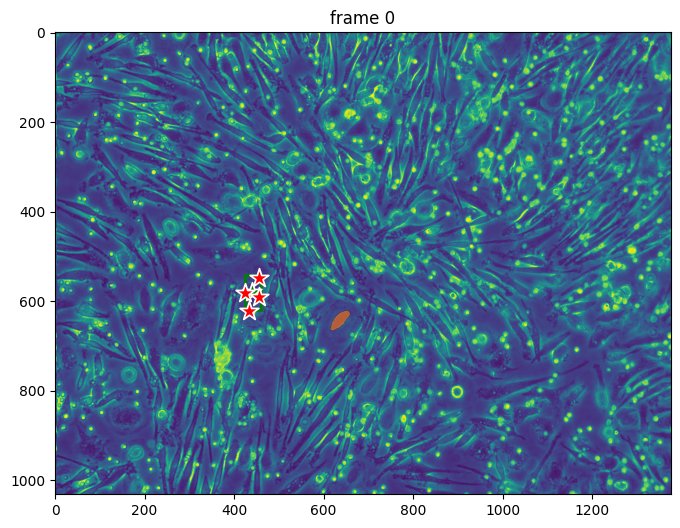

In [36]:
ann_frame_idx = 0
ann_obj_id = 5

points = np.array([[441, 579],[456, 549],[455, 591],[434, 622],[424, 581]], dtype=np.float32)

labels = np.array([1,0,0,0,0], np.int32)

box = np.array([425, 541, 460, 620], dtype=np.float32) # (x_min, y_min, x_max, y_max)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
    box=box,
)

plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

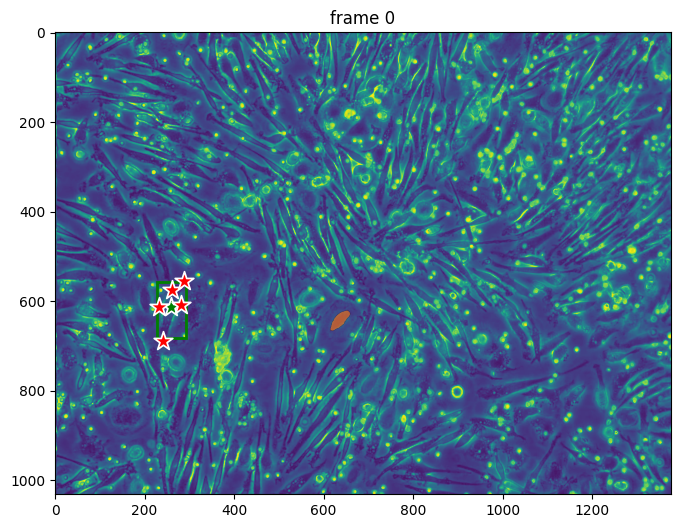

In [37]:
ann_frame_idx = 0
ann_obj_id = 6

points = np.array([[260, 613],[282, 609],[233, 614],[261, 576],[242, 689],[289, 554]], dtype=np.float32)

labels = np.array([1,0,0,0,0,0], np.int32)

box = np.array([227, 558, 292, 683], dtype=np.float32) # (x_min, y_min, x_max, y_max)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
    box=box,
)

plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

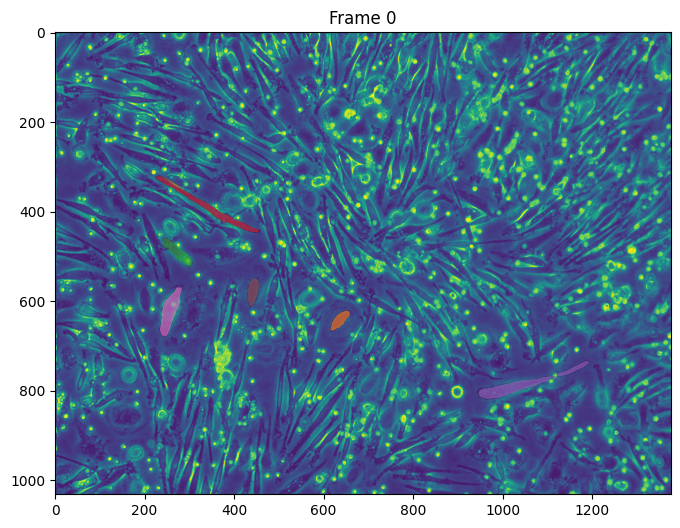

In [38]:
first_frame_segments = {}

out_frame_idx = 0
for i, out_obj_id in enumerate(out_obj_ids):
    out_mask = (out_mask_logits[i] > 0).cpu().numpy()
    first_frame_segments[out_obj_id] = out_mask

plt.figure(figsize=(9, 6))
plt.title(f"Frame {out_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))

for out_obj_id, out_mask in first_frame_segments.items():
    show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

plt.show()

In [ ]:
video_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

vis_frame_stride = 60
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [ ]:
import numpy as np
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt

output_video_path = "/content/segmented_video.mp4"

sample_frame_path = os.path.join(video_dir, frame_names[0])
sample_frame = Image.open(sample_frame_path)
frame_width, frame_height = sample_frame.size
fps = 8

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out_video = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

mask_color = [255, 0, 0]

for frame_idx in range(len(frame_names)):
    frame_path = os.path.join(video_dir, frame_names[frame_idx])
    frame = Image.open(frame_path).convert("RGB")
    frame = np.array(frame)

    mask_overlay = frame.copy()

    if frame_idx in video_segments:
        for out_obj_id, out_mask in video_segments[frame_idx].items():
            out_mask = np.squeeze(out_mask)
            if out_mask.shape != frame.shape[:2]:
                raise ValueError(f"mask size {out_mask.shape} frame size {frame.shape[:2]} not match")
            mask_colored = np.zeros_like(frame)
            mask_colored[out_mask > 0] = mask_color
            mask_overlay = cv2.addWeighted(mask_overlay, 0.7, mask_colored, 0.3, 0)

    frame_bgr = cv2.cvtColor(mask_overlay, cv2.COLOR_RGB2BGR)

    out_video.write(frame_bgr)

out_video.release()
print("video saved as segmented_video.mp4")

from IPython.display import HTML
from base64 import b64encode

def display_video(video_path):
    mp4 = open(video_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(f"""
    <video width="640" height="480" controls>
          <source src="{data_url}" type="video/mp4">
    </video>
    """)

display_video(output_video_path)

video saved as segmented_video.mp4
Buffered data was truncated after reaching the output size limit.

In [ ]:
import numpy as np
import csv
import cv2

def calculate_compactness(perimeter, area):
    if area == 0:
        return 0
    return (perimeter ** 2) / (4 * np.pi * area)

def calculate_dispersion(mask):
    coords = np.column_stack(np.where(mask > 0))
    centroid = np.mean(coords, axis=0)
    dispersion = np.mean(np.linalg.norm(coords - centroid, axis=1))
    return dispersion

output_csv = 'segmentation_metrics.csv'

with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Frame', 'ObjectID', 'Area', 'Perimeter', 'Compactness', 'Dispersion'])

for frame_idx, objects in video_segments.items():
    for obj_id, mask in objects.items():
        mask_binary = np.squeeze(mask > 0).astype(np.uint8)

        if mask_binary is None or mask_binary.size == 0 or np.count_nonzero(mask_binary) == 0:
            print(f"No valid mask found for frame {frame_idx}, object {obj_id}. Skipping.")
            continue

        if len(mask_binary.shape) != 2:
            print(f"Mask is not single-channel: {mask_binary.shape}. Skipping.")
            continue

        area = np.count_nonzero(mask_binary)

        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        perimeter = sum(cv2.arcLength(contour, True) for contour in contours)

        compactness = calculate_compactness(perimeter, area)

        dispersion = calculate_dispersion(mask_binary)

        with open(output_csv, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([frame_idx, obj_id, area, perimeter, compactness, dispersion])

print(f"Segmentation metrics saved to {output_csv}")


No valid mask found for frame 417, object 1. Skipping.
No valid mask found for frame 417, object 2. Skipping.
No valid mask found for frame 427, object 1. Skipping.
No valid mask found for frame 427, object 2. Skipping.
No valid mask found for frame 461, object 1. Skipping.
No valid mask found for frame 461, object 2. Skipping.
No valid mask found for frame 564, object 1. Skipping.
No valid mask found for frame 564, object 2. Skipping.
No valid mask found for frame 565, object 1. Skipping.
No valid mask found for frame 565, object 2. Skipping.
No valid mask found for frame 566, object 1. Skipping.
No valid mask found for frame 566, object 2. Skipping.
No valid mask found for frame 567, object 1. Skipping.
No valid mask found for frame 567, object 2. Skipping.
No valid mask found for frame 568, object 1. Skipping.
No valid mask found for frame 568, object 2. Skipping.
No valid mask found for frame 569, object 1. Skipping.
No valid mask found for frame 569, object 2. Skipping.
Segmentati

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

segmented_image_folder = "segmented_with_color_filter"
os.makedirs(segmented_image_folder, exist_ok=True)

mask_output_folder = "masks/"
os.makedirs(mask_output_folder, exist_ok=True)
cell_counts = []

lower_green = np.array([40, 40, 40])
upper_green = np.array([80, 255, 255])

for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    frame_path = os.path.join(video_dir, frame_names[out_frame_idx])
    frame = cv2.imread(frame_path)

    total_cells_in_frame = 0

    for obj_id, mask in zip(out_obj_ids, out_mask_logits):
        binary_mask = (mask[0].cpu().numpy() > 0).astype(np.uint8)
        masked_frame = cv2.bitwise_and(frame, frame, mask=binary_mask)
        image_hsv = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2HSV)
        color_filtered_mask = cv2.inRange(image_hsv, lower_green, upper_green)
        kernel = np.ones((3, 3), np.uint8)
        morph_open = cv2.morphologyEx(color_filtered_mask, cv2.MORPH_OPEN, kernel, iterations=2)
        contours, _ = cv2.findContours(morph_open, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cell_count = len(contours)
        total_cells_in_frame += cell_count

        output_image = frame.copy()
        cv2.drawContours(output_image, contours, -1, (0, 0, 255), 2)
        cv2.putText(output_image, f'Cell Count: {cell_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        output_image_path = os.path.join(segmented_image_folder, f"frame_{out_frame_idx:04d}_obj_{obj_id}.png")
        cv2.imwrite(output_image_path, output_image)

    cell_counts.append({'Frame': out_frame_idx, 'Total Cell Count': total_cells_in_frame})

output_csv_path = "cell_counts.csv"
df = pd.DataFrame(cell_counts)
df.to_csv(output_csv_path, index=False)

print(f"Cell counts saved to {output_csv_path}")
print(f"Segmented images saved to {segmented_image_folder}")


propagate in video: 100%|██████████| 570/570 [16:39<00:00,  1.75s/it]

Cell counts saved to cell_counts.csv
Segmented images saved to segmented_with_color_filter


In [ ]:
print(f"Total frames in video_segments: {len(video_segments)}")
for frame_idx, masks in video_segments.items():
    print(f"Frame {frame_idx}: {len(masks)} objects")

Total frames in video_segments: 570
Frame 0: 2 objects
Frame 1: 2 objects
Frame 2: 2 objects
Frame 3: 2 objects
Frame 4: 2 objects
Frame 5: 2 objects
Frame 6: 2 objects
Frame 7: 2 objects
Frame 8: 2 objects
Frame 9: 2 objects
Frame 10: 2 objects
Frame 11: 2 objects
Frame 12: 2 objects
Frame 13: 2 objects
Frame 14: 2 objects
Frame 15: 2 objects
Frame 16: 2 objects
Frame 17: 2 objects
Frame 18: 2 objects
Frame 19: 2 objects
Frame 20: 2 objects
Frame 21: 2 objects
Frame 22: 2 objects
Frame 23: 2 objects
Frame 24: 2 objects
Frame 25: 2 objects
Frame 26: 2 objects
Frame 27: 2 objects
Frame 28: 2 objects
Frame 29: 2 objects
Frame 30: 2 objects
Frame 31: 2 objects
Frame 32: 2 objects
Frame 33: 2 objects
Frame 34: 2 objects
Frame 35: 2 objects
Frame 36: 2 objects
Frame 37: 2 objects
Frame 38: 2 objects
Frame 39: 2 objects
Frame 40: 2 objects
Frame 41: 2 objects
Frame 42: 2 objects
Frame 43: 2 objects
Frame 44: 2 objects
Frame 45: 2 objects
Frame 46: 2 objects
Frame 47: 2 objects
Frame 48: 2 ob

In [ ]:
print(mask.shape)

(1, 1032, 1376)


In [ ]:
output_dir = '/content/drive/MyDrive/mask'
os.makedirs(output_dir, exist_ok=True)

for frame_idx, masks in video_segments.items():
    for obj_id, mask in masks.items():

        mask_image = np.squeeze(mask)
        mask_image = (mask_image * 255).astype(np.uint8)


        save_path = os.path.join(output_dir, f'frame_{frame_idx}_obj_{obj_id}.png')

        Image.fromarray(mask_image).save(save_path)
        print(f"Saved: {save_path}")


Saved: /content/drive/MyDrive/mask/frame_0_obj_1.png
Saved: /content/drive/MyDrive/mask/frame_0_obj_2.png
Saved: /content/drive/MyDrive/mask/frame_1_obj_1.png
Saved: /content/drive/MyDrive/mask/frame_1_obj_2.png
Saved: /content/drive/MyDrive/mask/frame_2_obj_1.png
Saved: /content/drive/MyDrive/mask/frame_2_obj_2.png
Saved: /content/drive/MyDrive/mask/frame_3_obj_1.png
Saved: /content/drive/MyDrive/mask/frame_3_obj_2.png
Saved: /content/drive/MyDrive/mask/frame_4_obj_1.png
Saved: /content/drive/MyDrive/mask/frame_4_obj_2.png
Saved: /content/drive/MyDrive/mask/frame_5_obj_1.png
Saved: /content/drive/MyDrive/mask/frame_5_obj_2.png
Saved: /content/drive/MyDrive/mask/frame_6_obj_1.png
Saved: /content/drive/MyDrive/mask/frame_6_obj_2.png
Saved: /content/drive/MyDrive/mask/frame_7_obj_1.png
Saved: /content/drive/MyDrive/mask/frame_7_obj_2.png
Saved: /content/drive/MyDrive/mask/frame_8_obj_1.png
Saved: /content/drive/MyDrive/mask/frame_8_obj_2.png
Saved: /content/drive/MyDrive/mask/frame_9_obj